In [1]:
import os
import sys
import re
from pathlib import Path
from itertools import combinations

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
from larval_gonad.notebook import Nb

In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook(seurat_dir='../output/scrnaseq-wf/scrnaseq_combine_force')

last updated: 2018-08-24 
Git hash: d860e817a227b978bd35bac75b3a4e77c27a36a0


## Absolute value heatmaps

In [247]:
zscores = pd.read_parquet('../output/scrnaseq-wf/tpm_zscore.parquet')

In [248]:
link = linkage(zscores, 'average')
tree = dendrogram(link, no_plot=True)
leaves = tree['leaves']

In [252]:
_order = zscores.iloc[leaves, :].index

In [231]:
raw = pd.read_parquet('../output/scrnaseq-wf/raw_by_cluster.parquet')

### All Genes

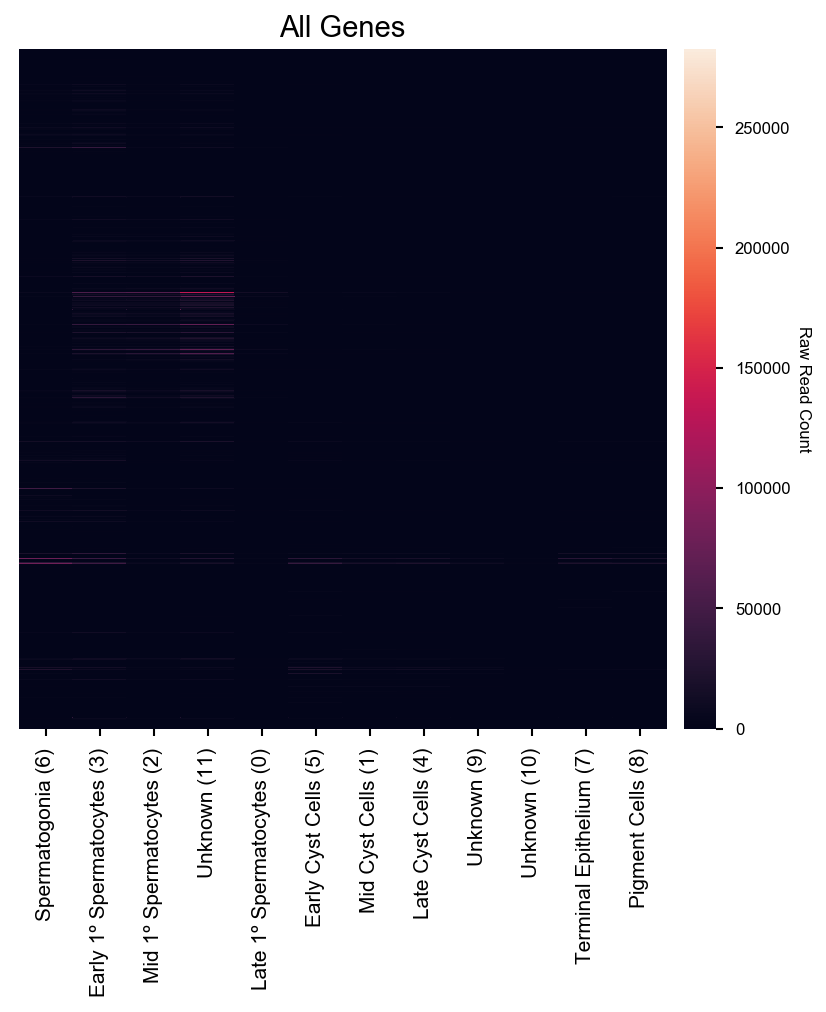

In [298]:
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 0.05], 'wspace': .05})
sns.heatmap(raw.reindex(_order).dropna(), yticklabels=False, ax=ax1, cbar_ax=ax2)
ax2.set_ylabel('Raw Read Count', rotation=-90, labelpad=10, fontsize=8)
ax1.set_ylabel('')
ax1.set_title('All Genes')
plt.setp(ax2.get_yticklabels(), fontsize=8);

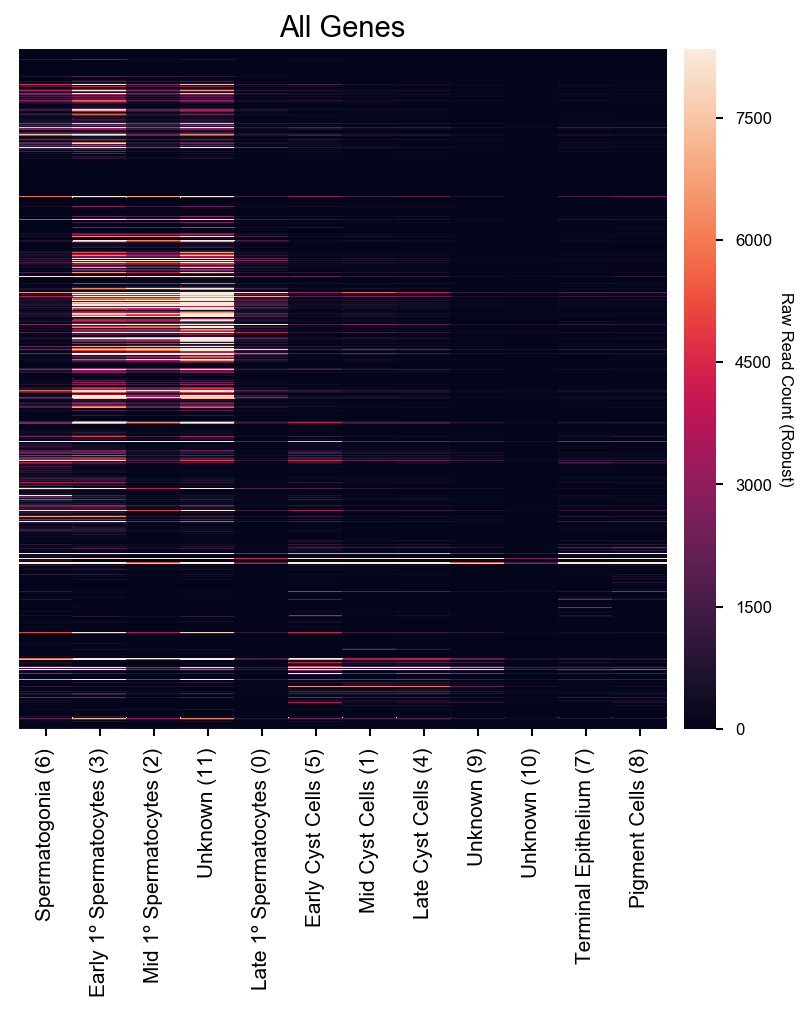

In [299]:
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 0.05], 'wspace': .05})
sns.heatmap(raw.reindex(_order).dropna(), yticklabels=False, ax=ax1, cbar_ax=ax2, robust=True)
ax2.set_ylabel('Raw Read Count (Robust)', rotation=-90, labelpad=10, fontsize=8)
ax1.set_ylabel('')
ax1.set_title('All Genes')
plt.setp(ax2.get_yticklabels(), fontsize=8);

### X-linked Genes

In [235]:
_dat = raw.join(nbconfig.fbgn2chrom).query('chrom == "chrX"').drop('chrom', axis=1)

Text(0.5,1,'X-linked Genes')

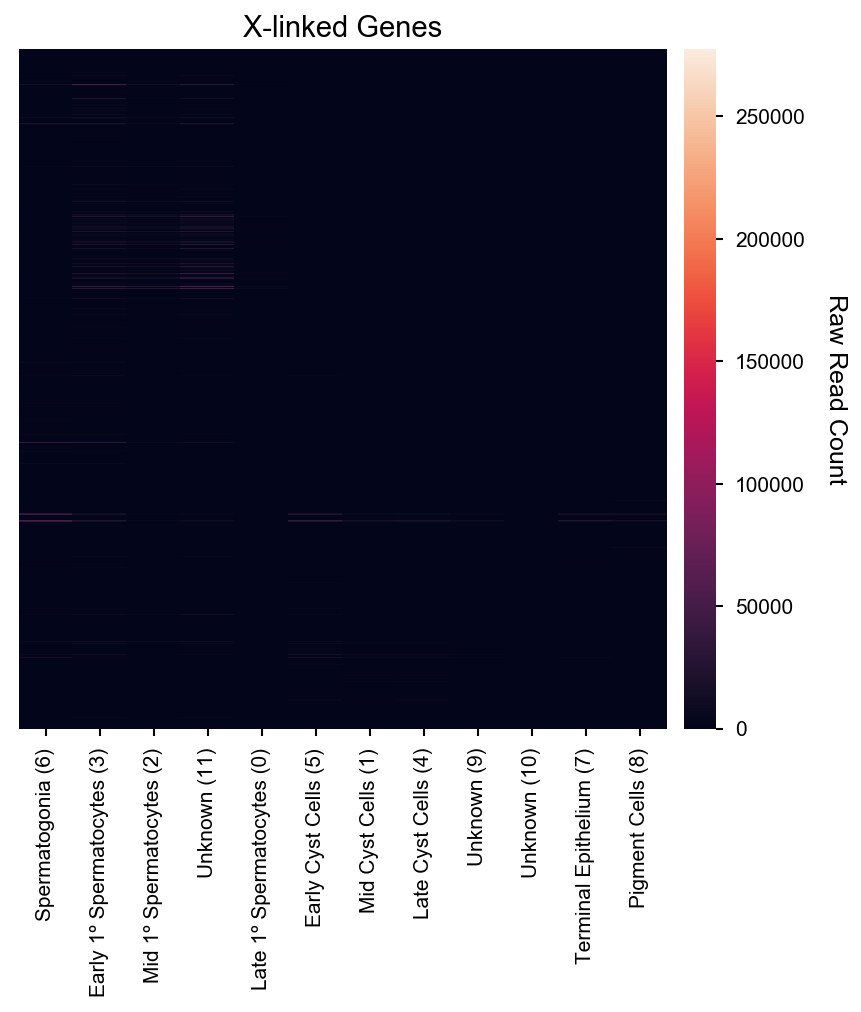

In [277]:
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, .05], 'wspace': .05})
sns.heatmap(_dat.reindex(_order).dropna(), yticklabels=False, ax=ax1, cbar_ax=ax2)
ax2.set_ylabel('Raw Read Count', rotation=-90, labelpad=20)
ax1.set_ylabel('')
ax1.set_title('X-linked Genes')

Text(0.5,1,'X-linked Genes')

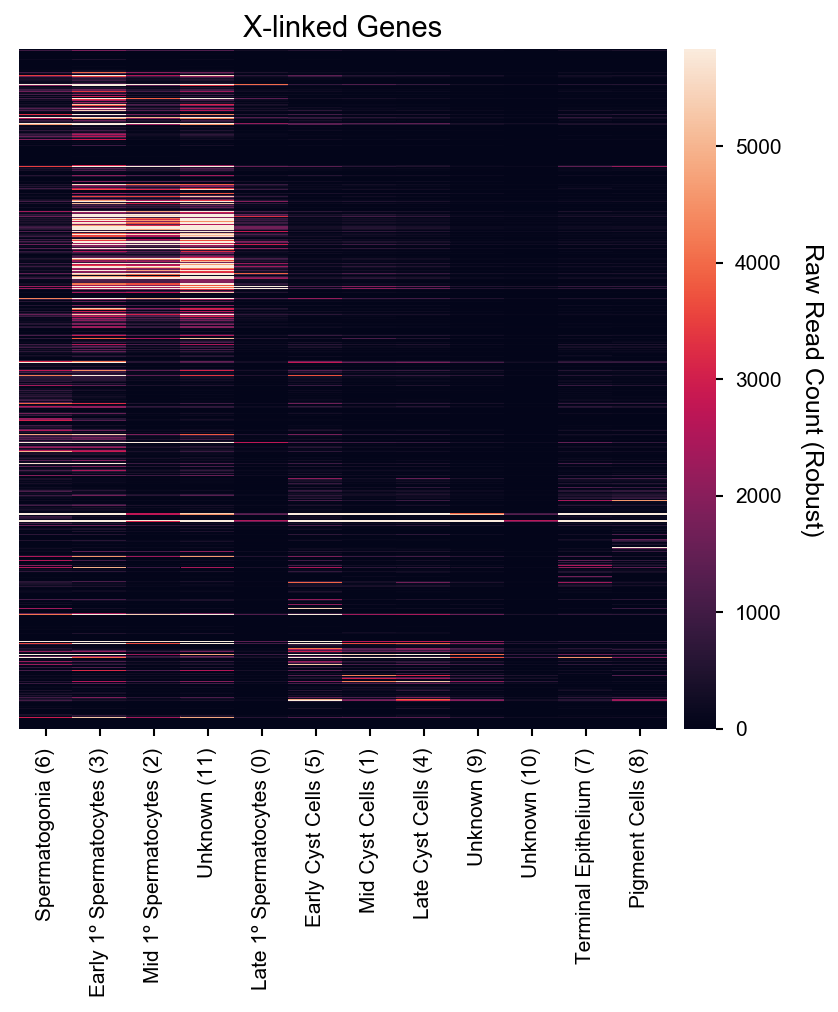

In [278]:
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, .05], 'wspace': .05})
sns.heatmap(_dat.reindex(_order).dropna(), yticklabels=False, ax=ax1, cbar_ax=ax2, robust=True)
ax2.set_ylabel('Raw Read Count (Robust)', rotation=-90, labelpad=20)
ax1.set_ylabel('')
ax1.set_title('X-linked Genes')

### Y-linked Genes

In [300]:
_dat = raw.join(nbconfig.fbgn2chrom).query('chrom == "chrY"').drop('chrom', axis=1)

In [305]:
_dat = _dat.reindex(_order).dropna()

In [307]:
_dat.index = [nbconfig.fbgn2symbol[x] for x in _dat.index]

Text(0.5,1,'Y-linked Genes')

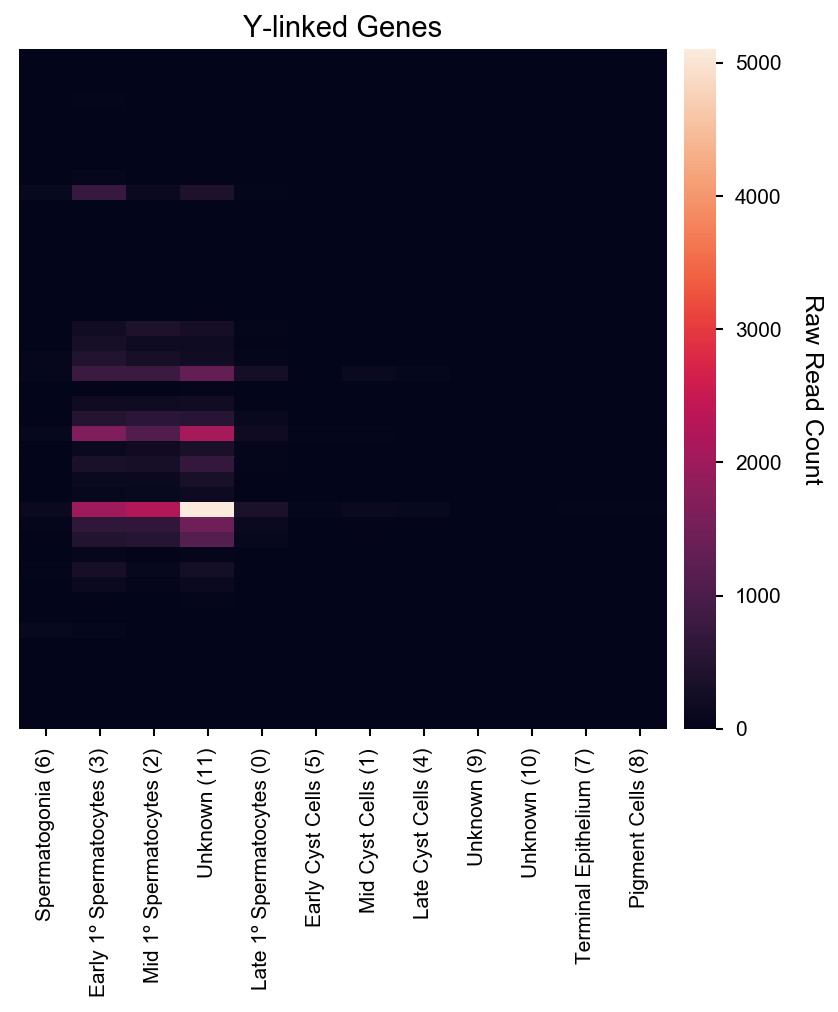

In [313]:
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, .05], 'wspace': .05})
sns.heatmap(_dat, yticklabels=False, ax=ax1, cbar_ax=ax2)
ax2.set_ylabel('Raw Read Count', rotation=-90, labelpad=20)
ax1.set_ylabel('')
ax1.set_title('Y-linked Genes')

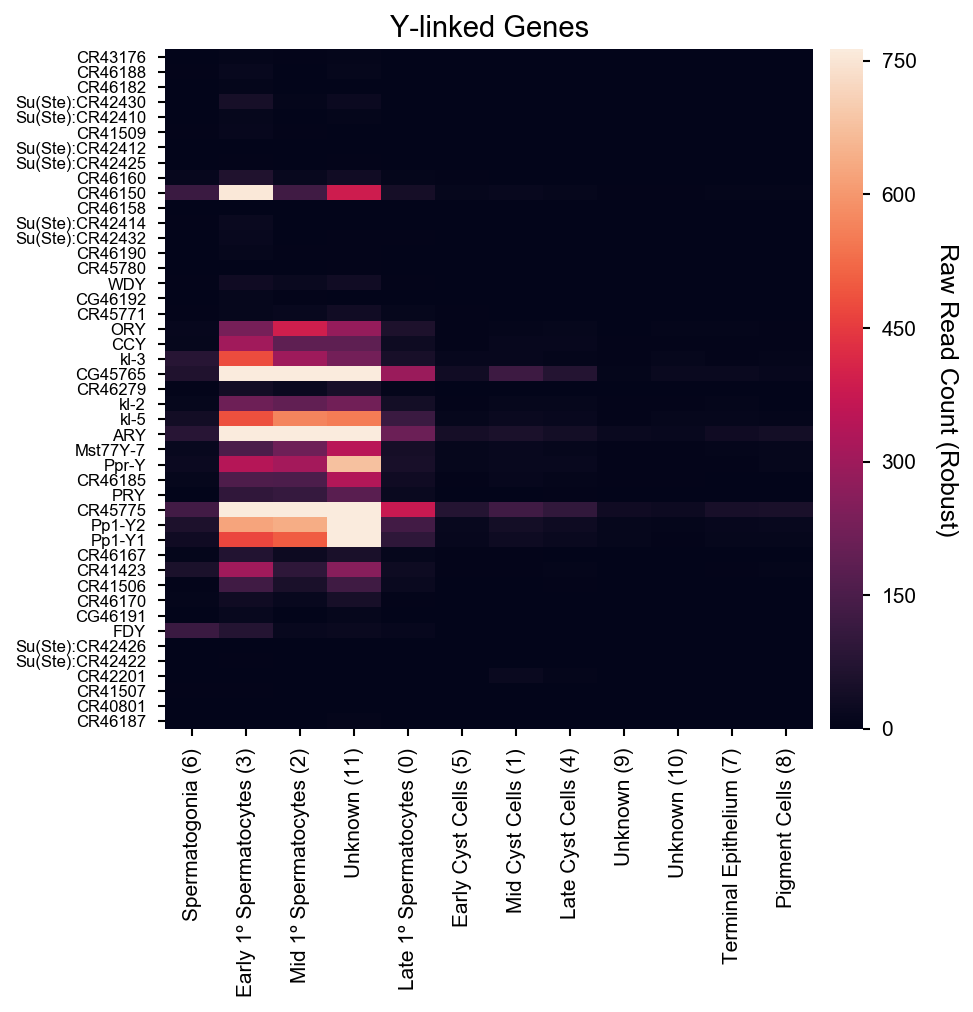

In [312]:
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, .05], 'wspace': .05})
sns.heatmap(_dat, yticklabels=True, ax=ax1, cbar_ax=ax2, robust=True)
ax2.set_ylabel('Raw Read Count (Robust)', rotation=-90, labelpad=20)
ax1.set_ylabel('')
ax1.set_title('Y-linked Genes')
plt.setp(ax1.get_yticklabels(), fontsize=8);

## Chromosomal distribution of DEG among germline

In [111]:
def diffs(up='gonia', down='cytes'):
    dat = pd.read_csv(f'../output/scrnaseq-wf/{up}_vs_{down}.tsv', sep='\t', index_col=0).query('p_val_adj <= 0.01')
    dat = dat.join(nbconfig.fbgn2chrom)

    dat[f'{up}'] = dat.avg_logFC > 0
    dat[f'{down}'] = dat.avg_logFC < 0

    chrs = ['chrX', 'chr2L', 'chr2R', 'chr3L', 'chr3R', 'chr4', 'chrY', 'chrM']
    df = dat[[f'{up}', f'{down}', 'chrom']].groupby('chrom').sum().reindex(chrs)
    df.columns = pd.MultiIndex.from_arrays([(f'{up}_vs_{down}', f'{up}_vs_{down}'), (f'{up}', f'{down}')])
    return df.fillna(0)

### Gonia vs 1º Spermatocytes

In [112]:
pd.concat([diffs('gonia', 'cytes'), diffs('gonia', 'early'), diffs('gonia', 'mid'),
           diffs('gonia', 'late'), diffs('gonia', 'eleven')], axis=1)

gonia_vs_cytes        gonia_vs_early        gonia_vs_mid         \
               gonia  cytes          gonia  early        gonia    mid   
chrom                                                                   
chrX           240.0  237.0          171.0  266.0        280.0  246.0   
chr2L          270.0  427.0          207.0  468.0        321.0  447.0   
chr2R          350.0  385.0          265.0  433.0        401.0  408.0   
chr3L          300.0  375.0          206.0  416.0        354.0  395.0   
chr3R          362.0  447.0          257.0  506.0        444.0  477.0   
chr4            18.0    5.0           14.0    5.0         22.0    5.0   
chrY             0.0    3.0            0.0    5.0          0.0    4.0   
chrM             0.0    7.0            0.0    6.0          0.0    2.0   

      gonia_vs_late        gonia_vs_eleven         
              gonia   late           gonia eleven  
chrom                                              
chrX          256.0  106.0           123.0  268.0  
chr2L         292.0  263.0           167.0  492.0  
chr2R         373.0  232.0           181.0  455.0  
chr3L         322.0  230.0           157.0  432.0  
chr3R         406.0  279.0           215.0  528.0  
chr4           21.0    1.0            11.0    6.0  
chrY            0.0    1.0             0.0    3.0  
chrM            0.0    8.0             7.0    0.0

### Lineage comparisons

In [113]:
pd.concat([diffs('gonia', 'early'), diffs('early', 'mid'), diffs('mid', 'late')], axis=1)

gonia_vs_early        early_vs_mid        mid_vs_late     
               gonia  early        early    mid         mid late
chrom                                                           
chrX           171.0  266.0        111.0   10.0         0.0  1.0
chr2L          207.0  468.0        158.0  103.0         2.0  6.0
chr2R          265.0  433.0        142.0  106.0         5.0  5.0
chr3L          206.0  416.0        126.0   75.0         6.0  3.0
chr3R          257.0  506.0        174.0  104.0         4.0  7.0
chr4            14.0    5.0          7.0    0.0         0.0  0.0
chrY             0.0    5.0          0.0    0.0         0.0  0.0
chrM             0.0    6.0          0.0    0.0         0.0  7.0

In [130]:
# X-linked genes with higher expression in mid 1º than early.
early_mid = pd.read_csv('../output/scrnaseq-wf/early_vs_mid.tsv', sep='\t', index_col=0).query('p_val_adj <= 0.01')
print(early_mid.join(nbconfig.fbgn2chrom).query('chrom == "chrX" & avg_logFC < 0').gene_symbol.tolist())

['CG1958', 'CG12689', 'CG11106', 'CG15198', 'CG12679', 'CG15577', 'CG15579', 'CR33218', 'CG45490', 'CG45603']


In [131]:
# X-linked genes with higher expression in late 1º than mid.
mid_late = pd.read_csv('../output/scrnaseq-wf/mid_vs_late.tsv', sep='\t', index_col=0).query('p_val_adj <= 0.01')
mid_late.join(nbconfig.fbgn2chrom).query('chrom == "chrX" & avg_logFC < 0').gene_symbol.tolist()

['MRE16']

### MA plots

In [29]:
tpm = pd.read_parquet('../output/scrnaseq-wf/tpm.parquet')
mapper = {
    'gonia': 'Spermatogonia (6)',
    'early': 'Early 1º Spermatocytes (3)',
    'mid': 'Mid 1º Spermatocytes (2)',
    'late': 'Late 1º Spermatocytes (0)',
    'eleven': 'Unknown (11)',
}

In [38]:
def plot_diff(up, down, ax, annot=None):
    _dat = pd.read_csv(f'../output/scrnaseq-wf/{up}_vs_{down}.tsv', sep='\t').query('p_val_adj <= 0.001').set_index('primary_FBgn')
    fup = _dat.index[_dat.avg_logFC > 0]
    fdown = _dat.index[_dat.avg_logFC < 0]
    _tpm = np.log10(tpm.loc[:, [mapper[up], mapper[down]]] + 1)

    _mean = _tpm.mean(axis=1)
    _diff = _tpm.iloc[:, 0] - _tpm.iloc[:, 1]

    ax.scatter(_mean, _diff, c='grey', alpha=.4, s=4)
    ax.scatter(_mean.reindex(fup), _diff.reindex(fup), c='b', s=4)
    ax.scatter(_mean.reindex(fdown), _diff.reindex(fdown), c='r', s=4)
    ax.axhline(0, color='k', ls='--')
    ax.set_title(f'{mapper[up]}\n{mapper[down]}', fontsize=6)
    ax.set_ylabel('Difference', fontsize=6)
    ax.set_xlabel('Mean Expression (log10 TPM)', fontsize=6)
    
    if annot:
        for gene in annot:
            fbgn = nbconfig.symbol2fbgn[gene]
            x = _mean[fbgn]
            y = _diff[fbgn]
            ax.text(x, y, gene, fontsize=8)
    

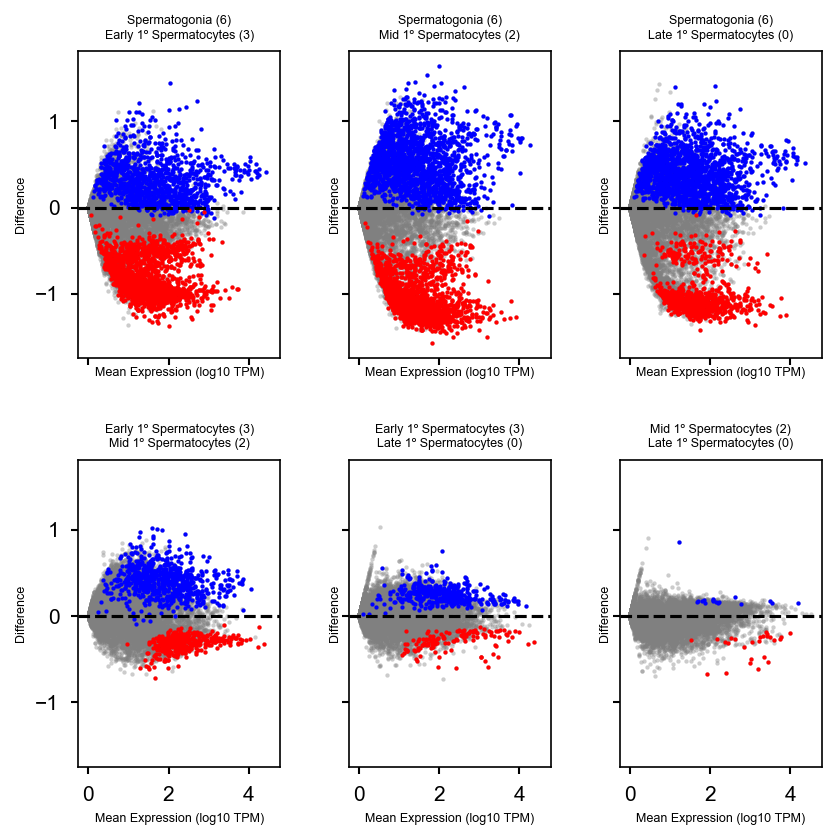

In [107]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True)

for ax, i in zip(axes.flatten(), combinations(['gonia', 'early', 'mid', 'late'], 2)):
    plot_diff(*i, ax)
    
plt.tight_layout()

In [ ]:
# What gene is high in mid when compared to late.
fig, ax = plt.subplots()
plot_diff('mid', 'late', ax, annot=['soti', 'CG13337', 'MRE16'])

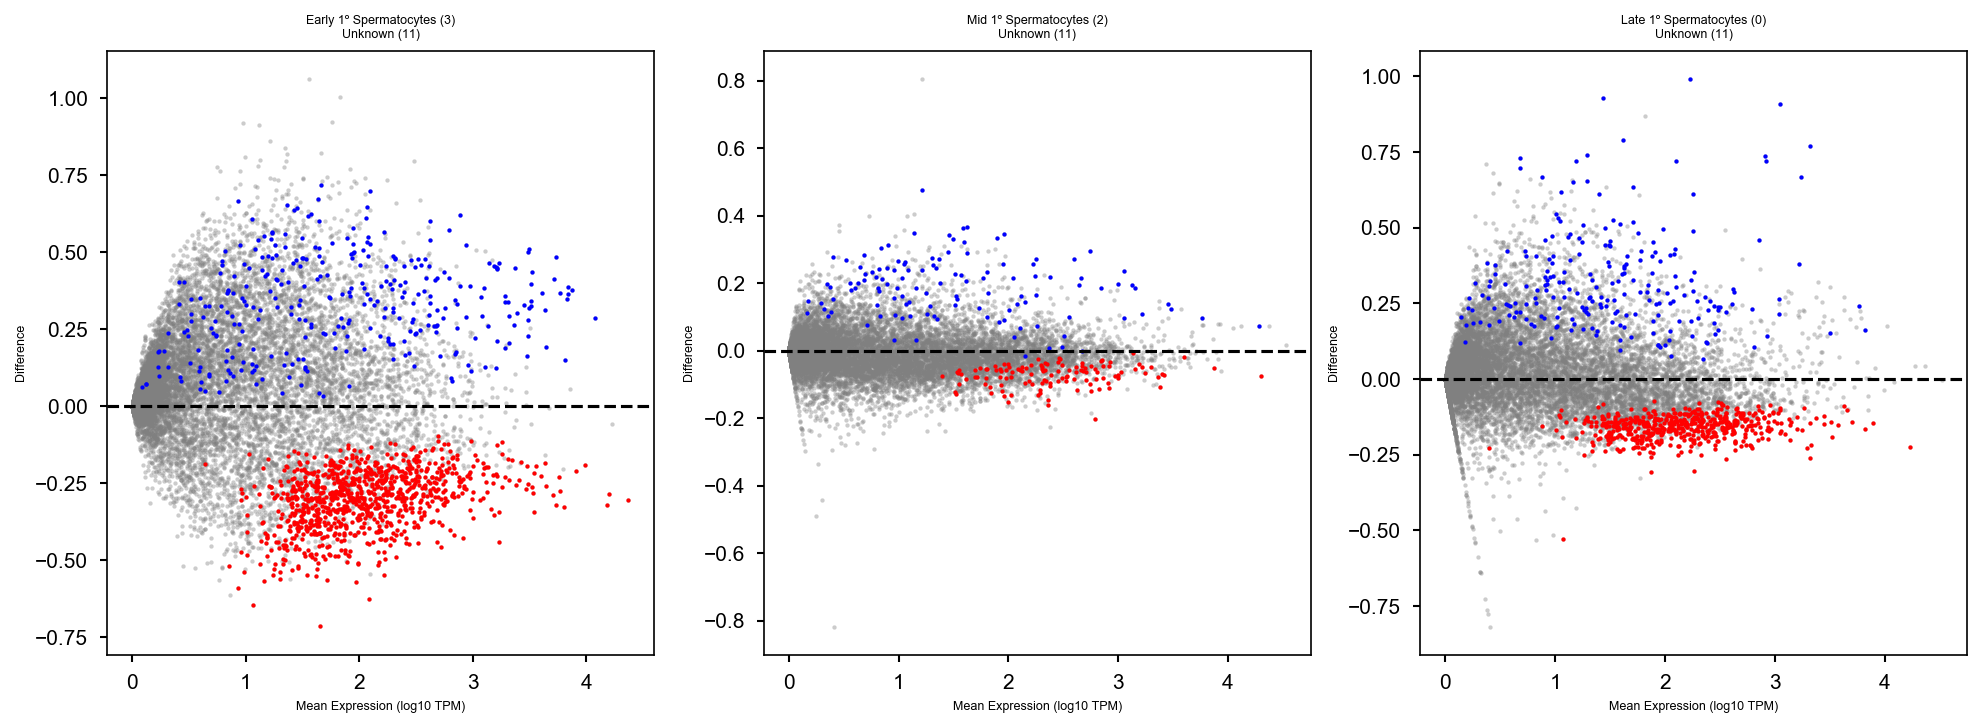

In [52]:
# how to germ cell clusters compare to cluster 11
fig, axes = plt.subplots(1, 3, figsize=plt.figaspect(1/3))
for ax, comp in zip(axes.flatten(), ['early', 'mid', 'late']):
    plot_diff(comp, 'eleven', ax)

## X To Autosome

In [3]:
chrom_mapper = {
    'chrX': 'X',
    'chr2L': 'A',
    'chr2R': 'A',
    'chr3L': 'A',
    'chr3R': 'A',
}

chroms = nbconfig.fbgn2chrom.chrom
chroms = chroms.map(chrom_mapper)

In [4]:
germ_cells = ['Spermatogonia (6)', 'Early 1º Spermatocytes (3)', 
              'Mid 1º Spermatocytes (2)', 'Late 1º Spermatocytes (0)']

In [5]:
clusters = nbconfig.seurat.get_clusters('res.0.6').map(nbconfig.cluster_annot)

### All Genes

#### Gene Distribution

##### Raw Counts

In [6]:
raw_agg = pd.read_parquet('../output/scrnaseq-wf/raw_by_cluster.parquet').iloc[:, :5]

Text(0.5,0.98,'All Genes (Gene Distribution)')

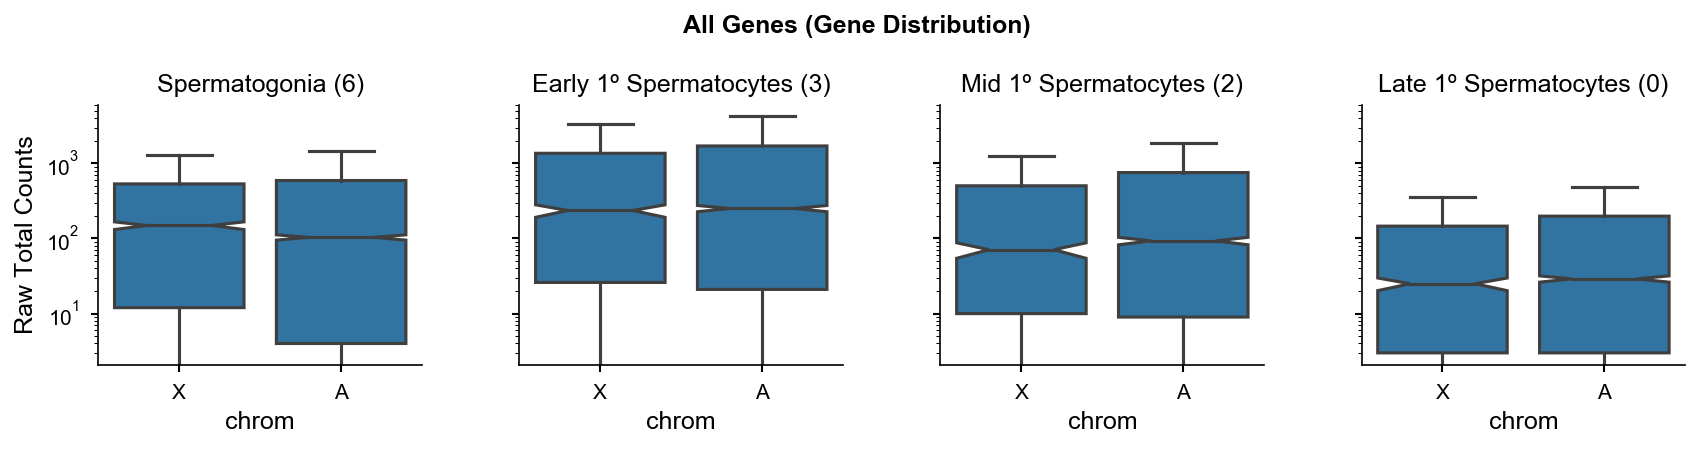

In [7]:
# Plot gene distribution by XA
_dat = raw_agg.reset_index().melt(id_vars='FBgn', var_name='Cluster', value_name='Raw Total Counts').set_index('FBgn').join(chroms)
g = sns.FacetGrid(_dat, col='Cluster', sharex=True, sharey=True, col_order=germ_cells)
g.map(sns.boxplot, 'chrom', 'Raw Total Counts', showfliers=False, notch=True, order=['X', 'A'])
g.set(yscale='log')
g.set_titles('{col_name}')
g.fig.suptitle('All Genes (Gene Distribution)', fontsize=12, va='bottom')

Text(0.5,0.98,'All Genes (Gene Distribution; Sampled)')

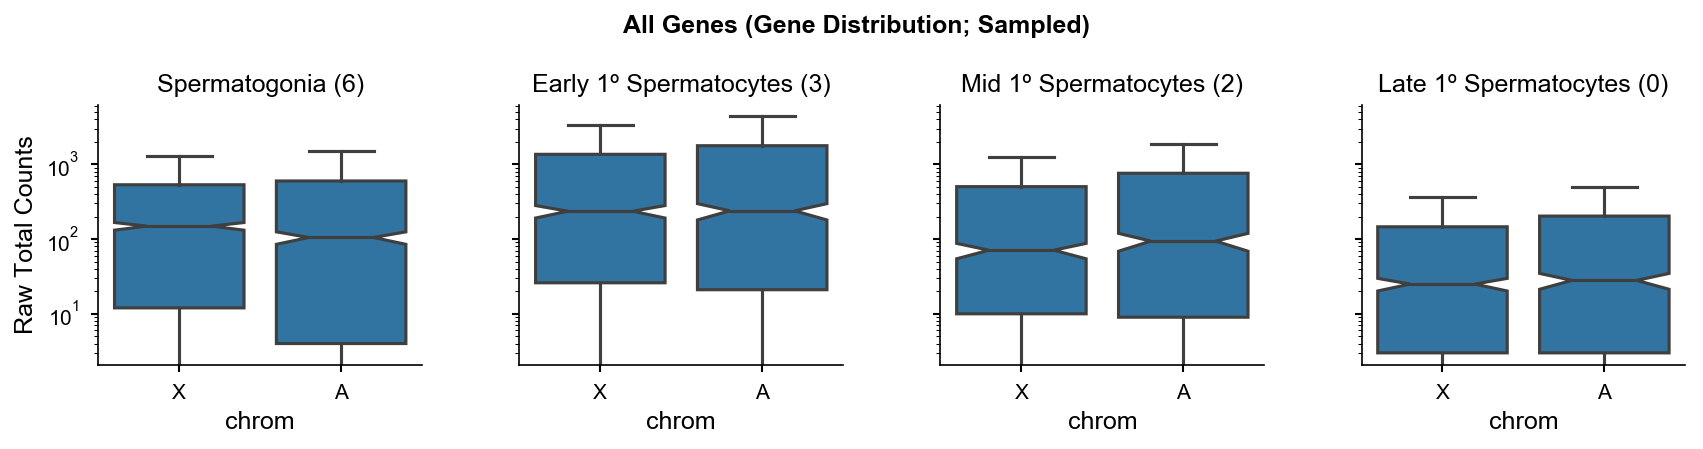

In [8]:
# Plot gene distribution by XA after sampling so X and A have an equal number of genes
x = raw_agg.join(chroms).query('chrom == "X"').index
a = raw_agg.join(chroms).query('chrom == "A"').index
ar = np.random.choice(a, size=x.shape[0], replace=False)
idx = ar.tolist() + x.tolist()

_dat = raw_agg.reindex(idx).reset_index().melt(id_vars='FBgn', var_name='Cluster', value_name='Raw Total Counts').set_index('FBgn').join(chroms)
g = sns.FacetGrid(_dat, col='Cluster', sharex=True, sharey=True, col_order=germ_cells)
g.map(sns.boxplot, 'chrom', 'Raw Total Counts', showfliers=False, notch=True, order=['X', 'A'])
g.set(yscale='log')
g.set_titles('{col_name}')
g.fig.suptitle('All Genes (Gene Distribution; Sampled)', fontsize=12, va='bottom')

##### TPM Counts

In [76]:
tpm = pd.read_parquet('../output/scrnaseq-wf/tpm.parquet').iloc[:, :5]

Text(0.5,0.98,'All Genes (Gene Distribution)')

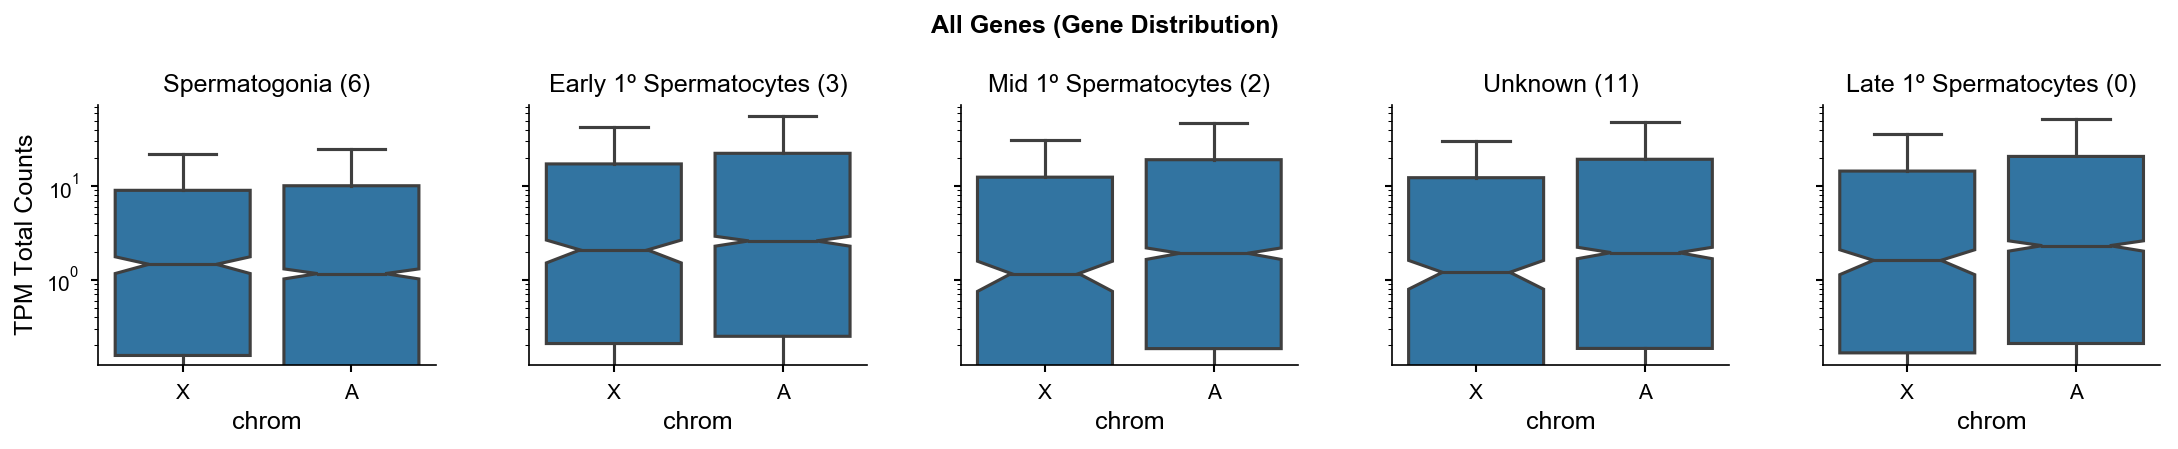

In [175]:
# Plot gene distribution by XA
_dat = tpm.reset_index().melt(id_vars='FBgn', var_name='Cluster', value_name='TPM Total Counts').set_index('FBgn').join(chroms)
g = sns.FacetGrid(_dat, col='Cluster', sharex=True, sharey=True, col_order=germ_cells)
g.map(sns.boxplot, 'chrom', 'TPM Total Counts', showfliers=False, notch=True, order=['X', 'A'])
g.set(yscale='log')
g.set_titles('{col_name}')
g.fig.suptitle('All Genes (Gene Distribution)', fontsize=12, va='bottom')

Text(0.5,0.98,'All Genes (Gene Distribution: Sampled)')

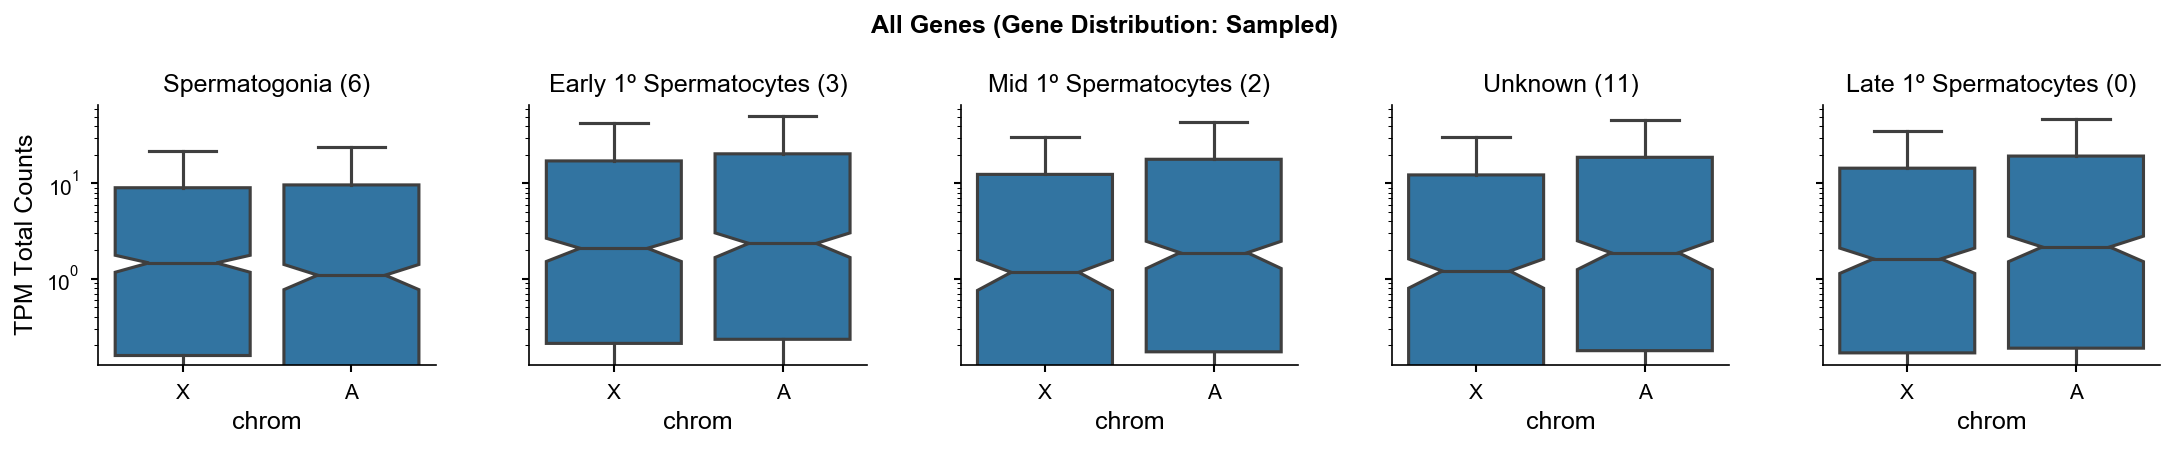

In [176]:
# Plot gene distribution by XA after sampling so X and A have an equal number of genes
x = tpm.join(chroms).query('chrom == "X"').index
a = tpm.join(chroms).query('chrom == "A"').index
ar = np.random.choice(a, size=x.shape[0], replace=False)
idx = ar.tolist() + x.tolist()

_dat = tpm.reindex(idx).reset_index().melt(id_vars='FBgn', var_name='Cluster', value_name='TPM Total Counts').set_index('FBgn').join(chroms)
g = sns.FacetGrid(_dat, col='Cluster', sharex=True, sharey=True, col_order=germ_cells)
g.map(sns.boxplot, 'chrom', 'TPM Total Counts', showfliers=False, notch=True, order=['X', 'A'])
g.set(yscale='log')
g.set_titles('{col_name}')
g.fig.suptitle('All Genes (Gene Distribution: Sampled)', fontsize=12, va='bottom')

#### Cell Distribution

##### Raw Counts

In [6]:
raw = pd.read_parquet('../output/scrnaseq-wf/raw.parquet', columns=clusters.index.tolist()).join(chroms)

Text(0.5,0.98,'All Genes (Cell Distribution)')

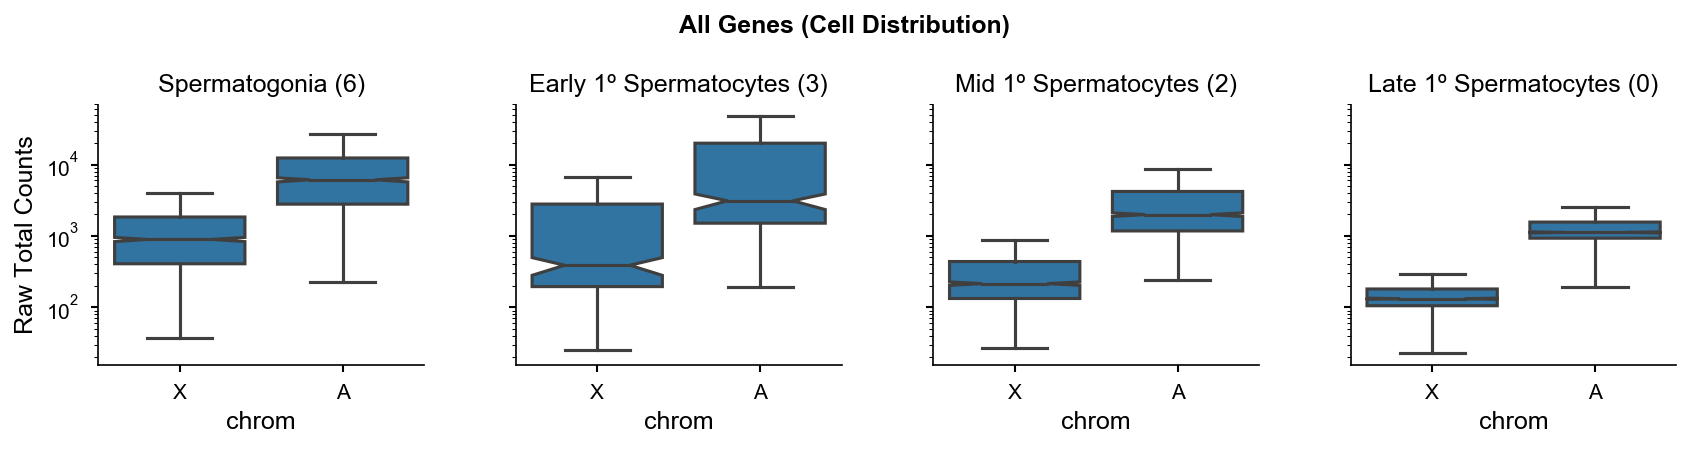

In [7]:
# Plot cell distribution by XA
cnts = raw.groupby('chrom').sum().T
cnts.index.name = 'cell_id'
_dat = cnts.reset_index().melt(id_vars='cell_id', var_name='chrom', value_name='Raw Total Counts').set_index('cell_id').join(clusters)
g = sns.FacetGrid(_dat, col='cluster', sharex=True, sharey=True, col_order=germ_cells)
g.map(sns.boxplot, 'chrom', 'Raw Total Counts', showfliers=False, notch=True, order=['X', 'A'])
g.set(yscale='log')
g.set_titles('{col_name}')
g.fig.suptitle('All Genes (Cell Distribution)', fontsize=12, va='bottom')

Text(0.5,0.98,'All Genes (Cell Distribution: Scaled)')

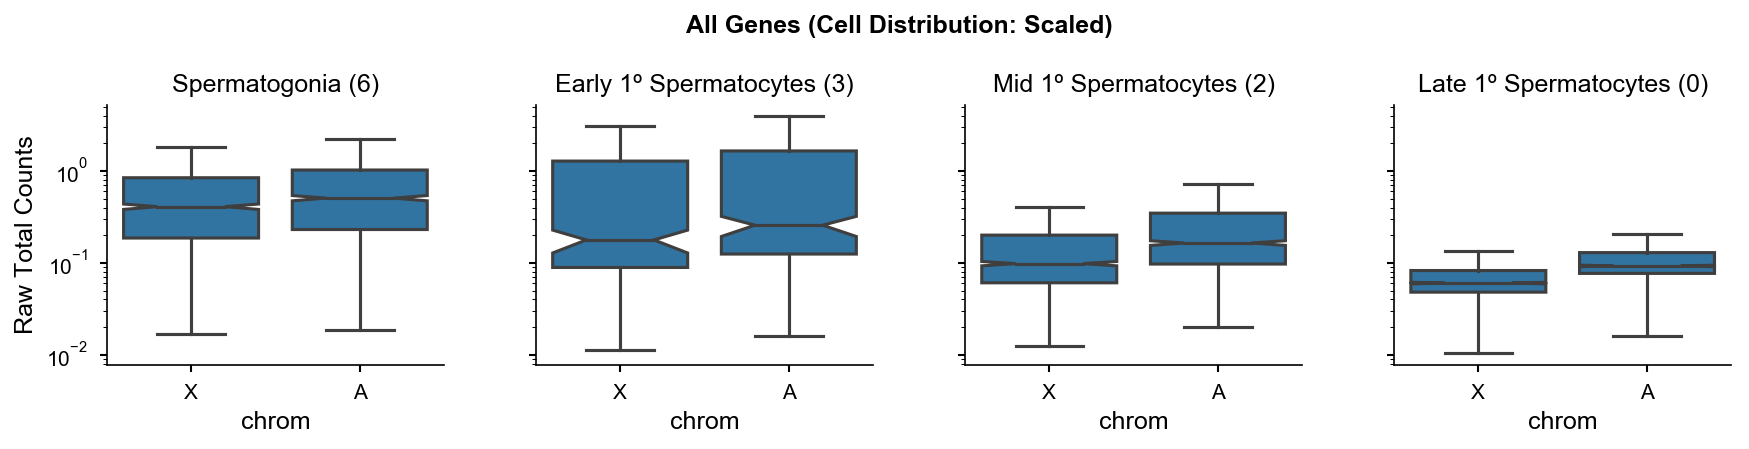

In [8]:
# Plot gene distribution by XA
cnts = raw.groupby('chrom').sum().div(raw.groupby('chrom').size(), axis=0).T
cnts.index.name = 'cell_id'
_dat = cnts.reset_index().melt(id_vars='cell_id', var_name='chrom', value_name='Raw Total Counts').set_index('cell_id').join(clusters)
g = sns.FacetGrid(_dat, col='cluster', sharex=True, sharey=True, col_order=germ_cells)
g.map(sns.boxplot, 'chrom', 'Raw Total Counts', showfliers=False, notch=True, order=['X', 'A'])
g.set(yscale='log')
g.set_titles('{col_name}')
g.fig.suptitle('All Genes (Cell Distribution: Scaled)', fontsize=12, va='bottom')

##### TPM Counts

In [3]:
from larval_gonad.normalization import tpm

In [10]:
raw = pd.read_parquet('../output/scrnaseq-wf/raw.parquet', columns=clusters.index.tolist())

In [11]:
gene_lengths = pd.read_csv('../output/gene_ts_lengths.tsv', sep='\t', index_col=0).gene_ts_length
gene_lengths.name = 'gene_length'

In [12]:
_tpm = tpm(raw, gene_lengths).dropna()
log_tpm = np.log10(_tpm + 1)

Text(0.5,0.98,'All Genes (Cell Distribution)')

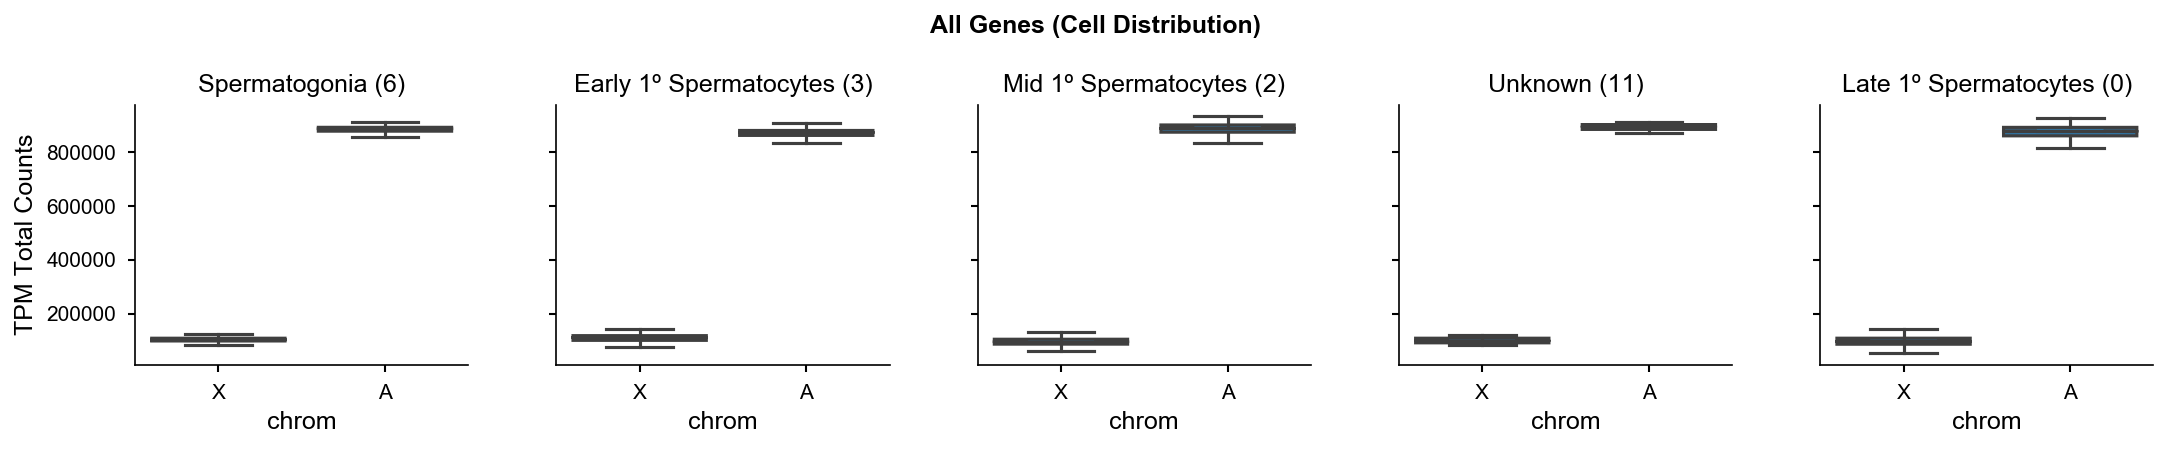

In [14]:
# Plot cell distribution by XA
cnts = _tpm.join(chroms).groupby('chrom').sum().T
cnts.index.name = 'cell_id'
_dat = cnts.reset_index().melt(id_vars='cell_id', var_name='chrom', value_name='TPM Total Counts').set_index('cell_id').join(clusters)
g = sns.FacetGrid(_dat, col='cluster', sharex=True, sharey=True, col_order=germ_cells)
g.map(sns.boxplot, 'chrom', 'TPM Total Counts', showfliers=False, notch=True, order=['X', 'A'])
#g.set(yscale='log')
g.set_titles('{col_name}')
g.fig.suptitle('All Genes (Cell Distribution)', fontsize=12, va='bottom')

In [16]:
_tpm.join(chroms).sum()

KeyboardInterrupt: 

### Up in Spermatocytes

Here I am focusing on genes that are up in spermatocytes compared to spermatogonia.

In [8]:
# Grab genes that are newly on in the cytes
gonia = pd.read_csv('../output/scrnaseq-wf/gonia_vs_cytes.tsv', sep='\t', index_col=0).query('p_val_adj <= 0.01')
cyteBias = gonia.query('avg_logFC < 0').index

#### Gene Distribution

In [8]:
raw_agg = pd.read_parquet('../output/scrnaseq-wf/raw_by_cluster.parquet', columns=germ_cells).reindex(cyteBias)
raw_agg.index.name = 'FBgn'

Text(0.5,0.98,'Cyte Biased Genes (Gene Distribution)')

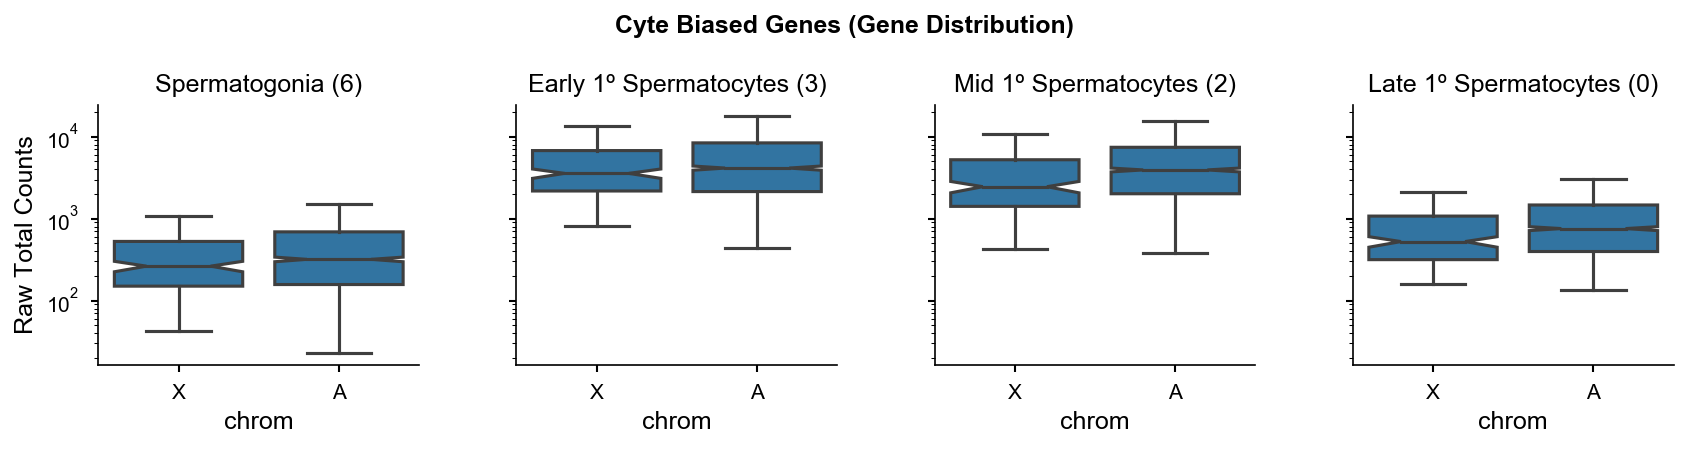

In [16]:
# Plot gene distribution by XA
_dat = raw_agg.reset_index().melt(id_vars='FBgn', var_name='Cluster', value_name='Raw Total Counts').set_index('FBgn').join(chroms)
g = sns.FacetGrid(_dat, col='Cluster', sharex=True, sharey=True, col_order=germ_cells)
g.map(sns.boxplot, 'chrom', 'Raw Total Counts', showfliers=False, notch=True, order=['X', 'A'])
g.set(yscale='log')
g.set_titles('{col_name}')
g.fig.suptitle('Cyte Biased Genes (Gene Distribution)', fontsize=12, va='bottom')

#### Cell Distribution

In [20]:
raw = pd.read_parquet('../output/scrnaseq-wf/raw.parquet', columns=clusters.index.tolist())\
    .reindex(cyteBias)\
    .join(chroms)

Text(0.5,0.98,'Cyte Biased Genes (Cell Distribution)')

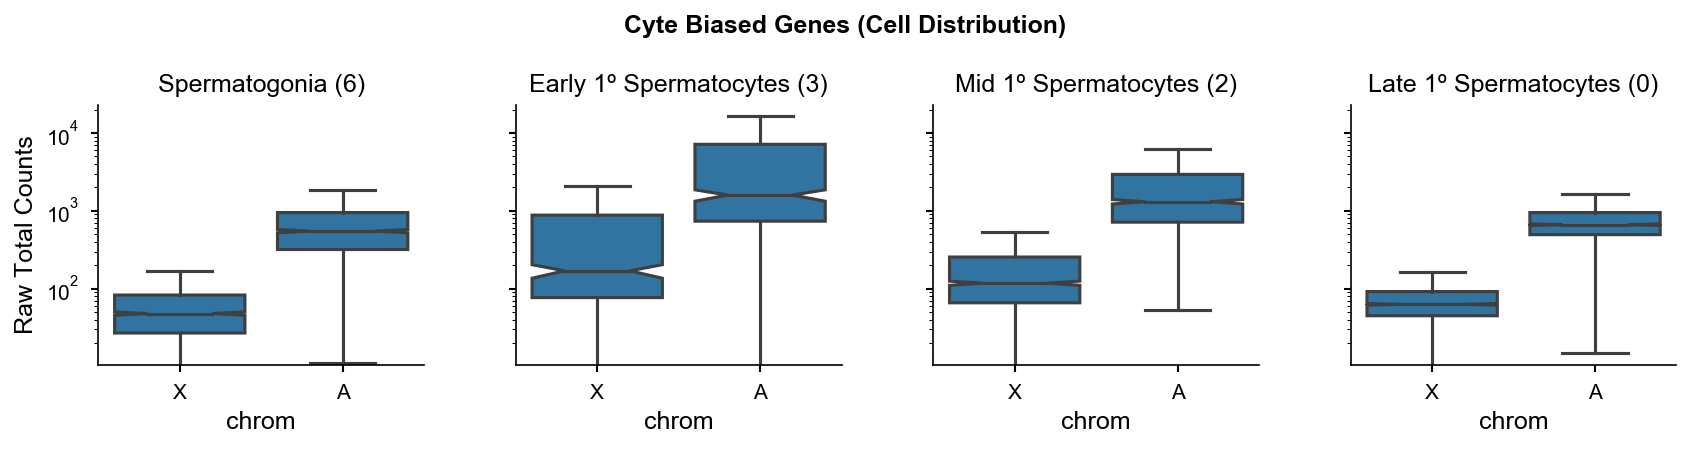

In [23]:
# Plot cell distribution by XA
cnts = raw.groupby('chrom').sum().T
cnts.index.name = 'cell_id'
_dat = cnts.reset_index().melt(id_vars='cell_id', var_name='chrom', value_name='Raw Total Counts').set_index('cell_id').join(clusters)
g = sns.FacetGrid(_dat, col='cluster', sharex=True, sharey=True, col_order=germ_cells)
g.map(sns.boxplot, 'chrom', 'Raw Total Counts', showfliers=False, notch=True, order=['X', 'A'])
g.set(yscale='log')
g.set_titles('{col_name}')
g.fig.suptitle('Cyte Biased Genes (Cell Distribution)', fontsize=12, va='bottom')

### Commonly Expressed

Here I am focusing on genes that are on in 1/3 of the germ cell data.

In [26]:
from larval_gonad.x_to_a import commonly_expressed

In [27]:
common = commonly_expressed(seurat_dir=nbconfig.seurat_dir)

#### Gene Distribution

In [29]:
raw_agg = pd.read_parquet('../output/scrnaseq-wf/raw_by_cluster.parquet', columns=germ_cells).reindex(common)
raw_agg.index.name = 'FBgn'

Text(0.5,0.98,'Commonly Expressed Genes (Gene Distribution)')

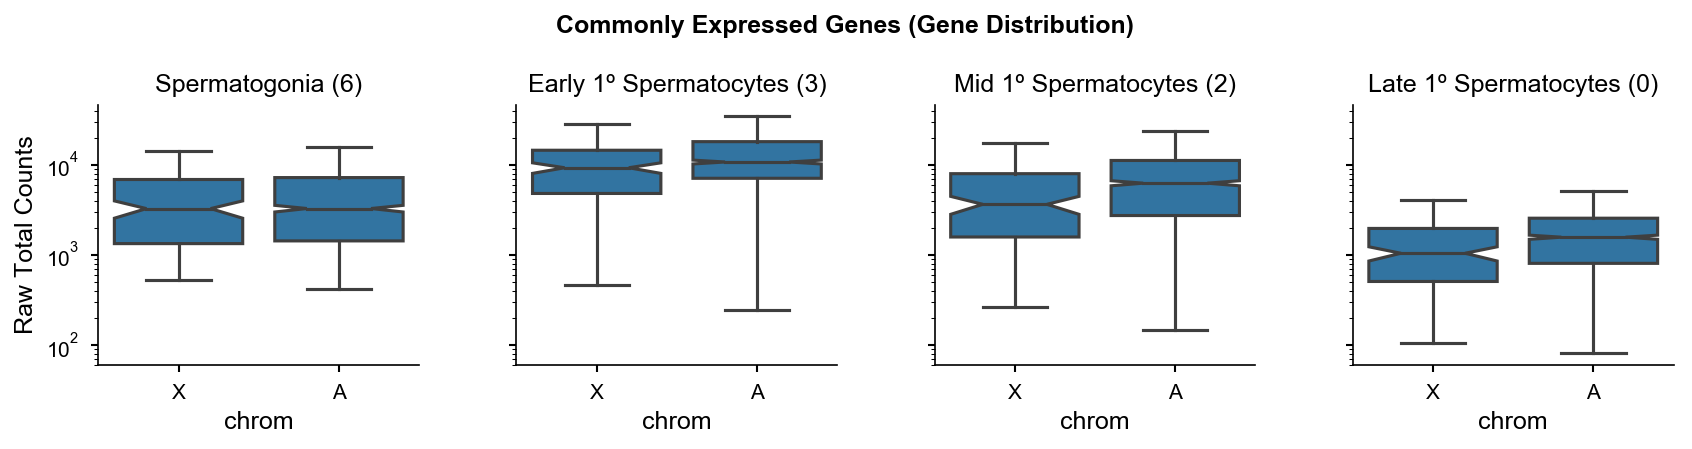

In [30]:
# Plot gene distribution by XA
_dat = raw_agg.reset_index().melt(id_vars='FBgn', var_name='Cluster', value_name='Raw Total Counts').set_index('FBgn').join(chroms)
g = sns.FacetGrid(_dat, col='Cluster', sharex=True, sharey=True, col_order=germ_cells)
g.map(sns.boxplot, 'chrom', 'Raw Total Counts', showfliers=False, notch=True, order=['X', 'A'])
g.set(yscale='log')
g.set_titles('{col_name}')
g.fig.suptitle('Commonly Expressed Genes (Gene Distribution)', fontsize=12, va='bottom')

#### Cell Distribution

In [33]:
raw = pd.read_parquet('../output/scrnaseq-wf/raw.parquet', columns=clusters.index.tolist())\
    .reindex(common)\
    .join(chroms)

Text(0.5,0.98,'Commonly Expressed Genes (Cell Distribution)')

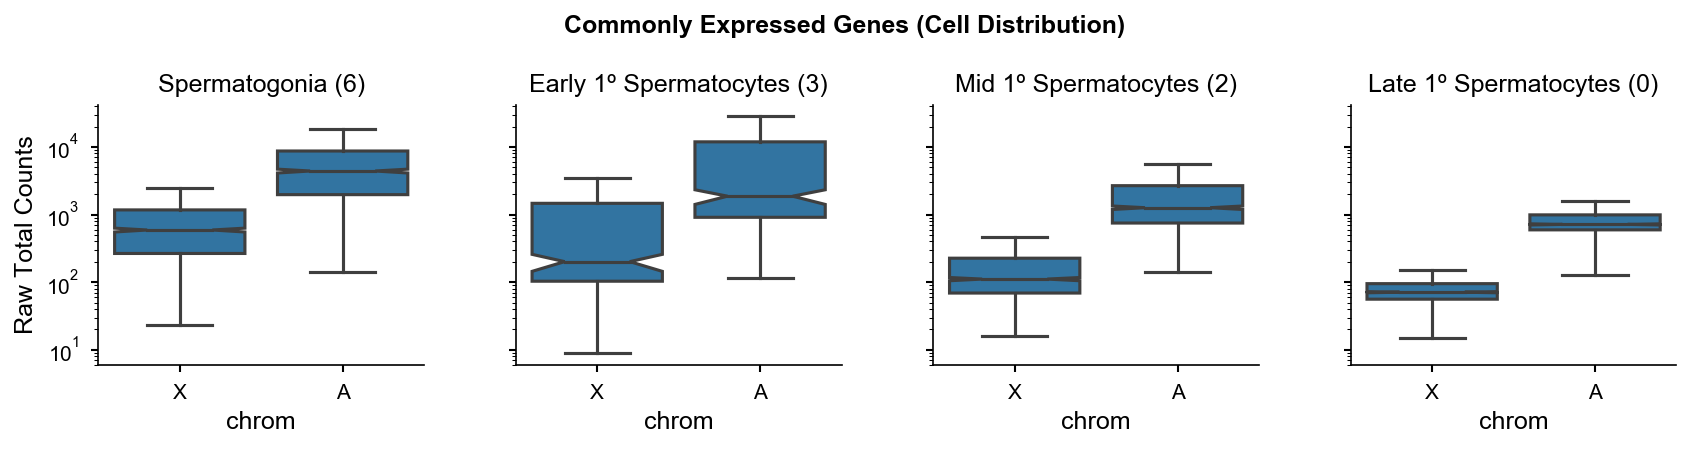

In [35]:
# Plot cell distribution by XA
cnts = raw.groupby('chrom').sum().T
cnts.index.name = 'cell_id'
_dat = cnts.reset_index().melt(id_vars='cell_id', var_name='chrom', value_name='Raw Total Counts').set_index('cell_id').join(clusters)
g = sns.FacetGrid(_dat, col='cluster', sharex=True, sharey=True, col_order=germ_cells)
g.map(sns.boxplot, 'chrom', 'Raw Total Counts', showfliers=False, notch=True, order=['X', 'A'])
g.set(yscale='log')
g.set_titles('{col_name}')
g.fig.suptitle('Commonly Expressed Genes (Cell Distribution)', fontsize=12, va='bottom')